In [1]:
import numpy as np
import matplotlib.pyplot as plt
from eomdp import utils as ut

In [2]:
# Performance comparisons: load data

rates = np.arange(5, 51, 5, dtype=np.float64)/100
bdepths = np.arange(2,11)/2

wcosts, scosts = np.zeros((3), np.float64), np.zeros((3), np.float64)
mdpcosts = np.zeros((3, len(rates), len(bdepths)), np.float64)
lbs = np.zeros((3, len(rates)), np.float64)
nvcosts = np.zeros((3, len(rates), len(bdepths)), np.float64)

sr_mdp = np.zeros((3,len(rates), len(bdepths)), np.float64)
sr_naive = np.zeros((3, len(rates), len(bdepths)), np.float64)

for c in range(3):
    for i,r in enumerate(rates):
        for j,b in enumerate(bdepths):
            dt = np.load('save/1cam_r%03d_bdepth%d_cost%d.npz' % (int(r*1000), int(b*10), c))
            wcosts[c] = dt['wcost']
            scosts[c] = dt['scost']
            lbs[c,i] = dt['lb']
            mdpcosts[c,i,j] = dt['mdpcost']
            nvcosts[c,i,j] = dt['naivecost']
            
            sr_mdp[c,i,j] = np.sum(dt['send_s'])
            sr_naive[c,i,j] = np.sum(dt['nsrate'])

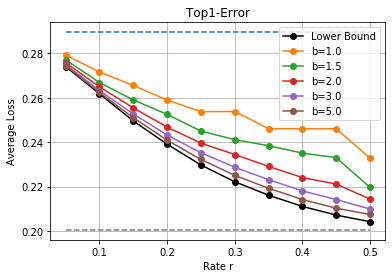

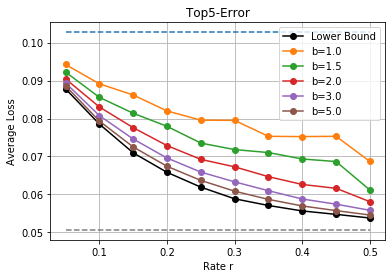

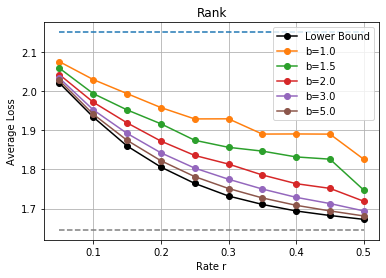

In [3]:
for c in range(3):
    plt.Figure()
    plt.plot(rates, [wcosts[c]]*len(rates), '--C0')
    plt.plot(rates, [scosts[c]]*len(rates), '--C7')
    plt.plot(rates, lbs[c,:], '-ok', label='Lower Bound')
    plt.plot(rates, mdpcosts[c,:,0], '-oC1', label='b=1.0')
    plt.plot(rates, mdpcosts[c,:,1], '-oC2', label='b=1.5')
    plt.plot(rates, mdpcosts[c,:,2], '-oC3', label='b=2.0')
    plt.plot(rates, mdpcosts[c,:,4], '-oC4', label='b=3.0')
    plt.plot(rates, mdpcosts[c,:,8], '-oC5', label='b=5.0')
    plt.ylabel('Average Loss'); plt.xlabel('Rate r'); plt.title(ut._COSTS[c]) 
    plt.grid(); plt.legend(loc='upper right'); plt.show();

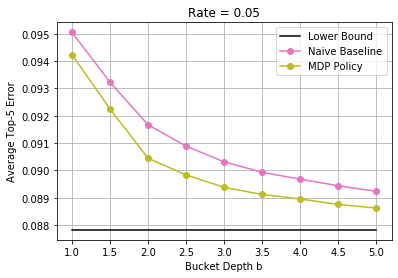

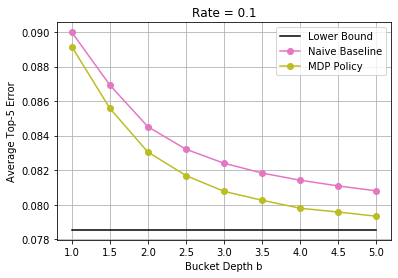

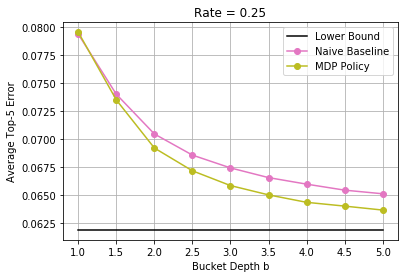

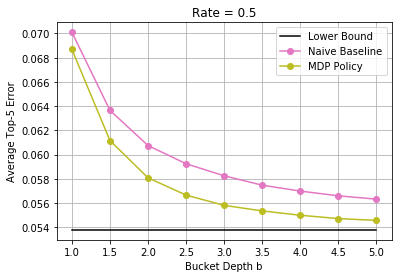

In [4]:
# Comparisons to naive baseline, for one of the costs.

c = 1
for ri in [0, 1, 4, 9]: # rates = 0.05, 0.1, 0.25, 0.5
    plt.Figure()
    plt.plot(bdepths, [lbs[c,ri]]*len(bdepths), '-k', label='Lower Bound')
    plt.plot(bdepths, nvcosts[c,ri,:], '-oC6', label='Naive Baseline')
    plt.plot(bdepths, mdpcosts[c,ri,:], '-oC8', label='MDP Policy')
    plt.ylabel('Average Top-5 Error'); plt.xlabel("Bucket Depth b"); plt.title("Rate = " + str(rates[ri]))
    plt.legend(); plt.grid(); plt.show()

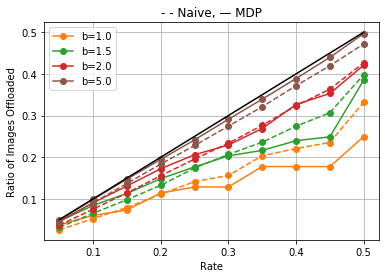

In [5]:
plt.Figure()
plt.plot(rates, sr_naive[c,:,0], '--oC1')
plt.plot(rates, sr_mdp[c,:,0], '-oC1', label='b=1.0')
plt.plot(rates, sr_naive[c,:,1], '--oC2')
plt.plot(rates, sr_mdp[c,:,1], '-oC2', label='b=1.5')
plt.plot(rates, sr_naive[c,:,2], '--oC3')
plt.plot(rates, sr_mdp[c,:,2], '-oC3', label='b=2.0')
plt.plot(rates, sr_naive[c,:,8], '--oC5')
plt.plot(rates, sr_mdp[c,:,8], '-oC5', label='b=5.0')

plt.plot(rates, rates, '-k')
plt.ylabel('Ratio of Images Offloaded'); plt.xlabel('Rate'); plt.title('- - Naive, — MDP'); 
plt.grid(); plt.legend(loc='upper left'); plt.show();

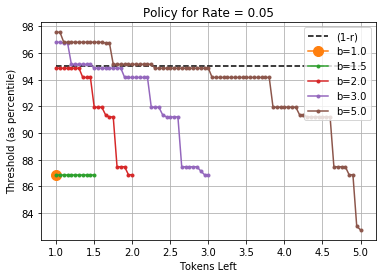

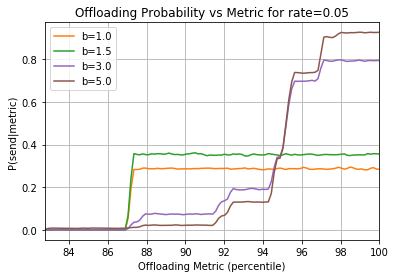

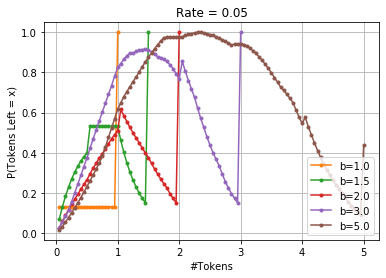

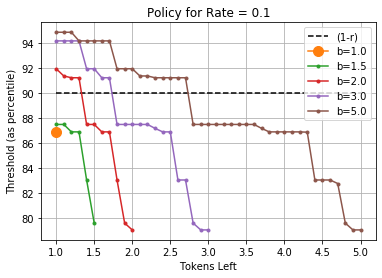

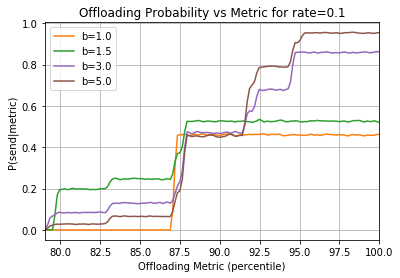

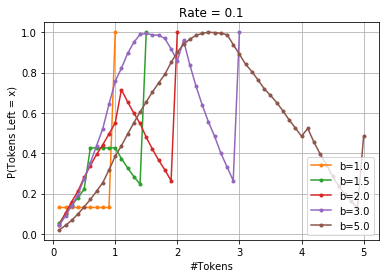

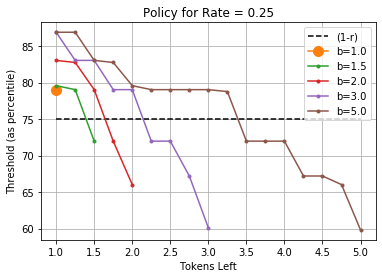

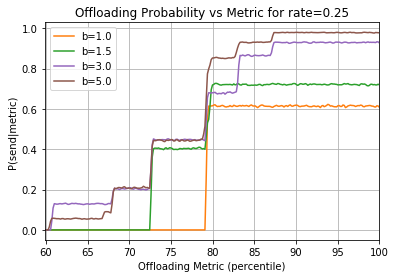

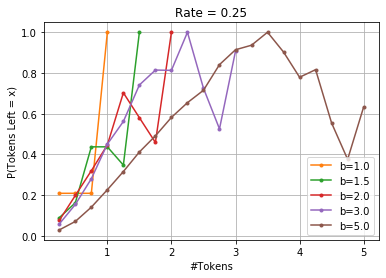

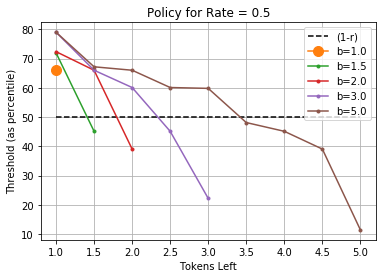

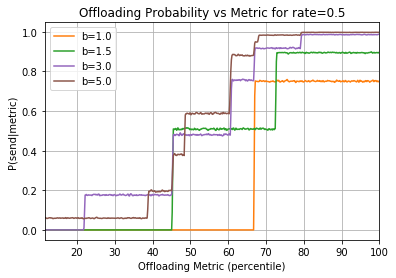

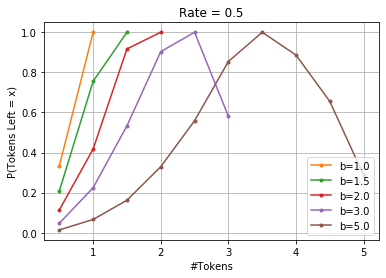

In [6]:
# Analyze policy and token bucket behavior

c=1
clrs = ['C1', 'C2', 'C3','C4','C5'] # Consistent colors for bucket width
bdepths = [1.0, 1.5, 2.0, 3.0, 5.0]
bsub = [0,1,3,4]
smsz=51

for ridx in [0, 1, 4, 9]: # rates = 0.05, 0.1, 0.25, 0.5
    rate = rates[ridx]
    policies, occups, thresh, sendms = [], [], [], []

    for b in range(len(bdepths)):
        dt = np.load('save/1cam_r%03d_bdepth%d_cost%d.npz' % (int(rate*1000), int(bdepths[b]*10), c))
        vx, px = ut.getvpidx(rate, bdepths[b])
        policies.append((px, dt['policy']))
        occups.append((vx, dt['occup_s']))
        sm = dt['send_m']
        smdnm = np.convolve(np.ones_like(sm), np.ones((smsz,)), 'VALID')
        sm = np.convolve(sm, np.ones((smsz,)),'VALID') / smdnm
        sendms.append(sm[::(smsz//2)])
      
    
    plt.Figure()
    plt.plot([1, bdepths[-1]], [(1-rate)*100]*2, '--k',label='(1-r)')
    for i in range(len(bdepths)):
        msize = 10 if i == 0 else 3
        plt.plot(policies[i][0], policies[i][1]*100.0, '-o'+clrs[i], markersize=msize, 
                 label=("b="+str(bdepths[i])))
    plt.xlabel('Tokens Left'); plt.ylabel('Threshold (as percentile)');
    plt.title("Policy for Rate = " + str(rate))
    plt.legend(loc='upper right'); plt.grid(); plt.show()
    
    plt.Figure()
    for i in bsub:    
        plt.plot(np.linspace(0,100,len(sendms[i])), sendms[i], '-'+clrs[i], label=('b='+str(bdepths[i])))
    plt.xlabel('Offloading Metric (percentile)'); plt.ylabel('P(send|metric)');
    plt.title('Offloading Probability vs Metric for rate='+str(rate))
    plt.xlim([np.amin(policies[-1])*100, 100])
    plt.legend(); plt.grid();plt.show()
    
    plt.Figure()
    for i in range(len(bdepths)):
        plt.plot(occups[i][0], (occups[i][1]/np.amax(occups[i][1])), '-o'+clrs[i], markersize=msize, 
                 label=("b="+str(bdepths[i])))
    plt.xlabel('#Tokens'); plt.ylabel('P(Tokens Left = x)');
    plt.title("Rate = " + str(rate));
    plt.legend(loc='lower right'); plt.grid(); plt.show()    